# Import Libraries

In [1]:
import numpy as np
import os
import warnings

import pandas as pd
from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

from src.utils import missing_values
from src.utils import detect_cardinality
from src.utils import evaluate_classification

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

C:\Users\metin\miniconda3\envs\ml2_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
sns.set(style='whitegrid')

In [3]:
# Set Some Configurations

ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data")
RAW_DATA_PATH = os.path.join(DATA_PATH, "raw")
PREPROCESS_DATA_PATH = os.path.join(DATA_PATH, 'preprocess')
OUTPUT_DATA_PATH = os.path.join(DATA_PATH, 'output')

ROOT_PATH, DATA_PATH, RAW_DATA_PATH, PREPROCESS_DATA_PATH, OUTPUT_DATA_PATH

('C:\\Users\\metin\\Desktop\\YTU\\2-BLM5110-ML\\Homeworks\\1-HeartDisease',
 'C:\\Users\\metin\\Desktop\\YTU\\2-BLM5110-ML\\Homeworks\\1-HeartDisease\\data',
 'C:\\Users\\metin\\Desktop\\YTU\\2-BLM5110-ML\\Homeworks\\1-HeartDisease\\data\\raw',
 'C:\\Users\\metin\\Desktop\\YTU\\2-BLM5110-ML\\Homeworks\\1-HeartDisease\\data\\preprocess',
 'C:\\Users\\metin\\Desktop\\YTU\\2-BLM5110-ML\\Homeworks\\1-HeartDisease\\data\\output')

# Step 1: Data Describe&Details, Null and Splitting

In [4]:
# Step 1:
# a. Ayırt edici özelliği olmayan (idNo vs. gibi) özellikler olup olmadığını kontrol ediniz. Varsa bu özellikleri kullanmayınız.
# b. Her örnek için boş bırakılmış özellik olup olmadığını kontrol ediniz. Eğer varsa o örnekleri kullanmayınız.
# c. Bu örnekler içinden rasgele seçeceğiniz %80’ini eğitim ve doğrulama, %20’sini test için kullanınız.

## Read Data

#### HeartDisease Dataset

In [5]:
df_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "heart.csv"))
df_data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#### O2Saturation Dataset

In [6]:
df_o2saturation = pd.read_csv(os.path.join(RAW_DATA_PATH, "o2Saturation.csv"))
df_o2saturation.head()

,98.6
0,98.6
1,98.6
2,98.6
3,98.1
4,97.5


In [7]:
df_o2saturation.describe().T

,count,mean,std,min,25%,50%,75%,max
98.6,3585.0,98.239275,0.726336,96.5,97.6,98.6,98.6,99.6


In [8]:
df_data.shape, df_o2saturation.shape

((303, 14), (3585, 1))

In [9]:
# "o2saturation" and "heartdisease" datasets shape is different and not related to each other therefore we will delete and not use "o2saturation" dataset
del df_o2saturation

In [10]:
df_data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [11]:
df_data.describe(percentiles=[0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,1%,5%,25%,50%,75%,95%,99%,100%,max
age,303.0,54.366337,9.082101,29.0,29.0,35.00,39.1,47.5,55.0,61.0,68.0,71.00,77.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,0.00,0.0,0.0,1.0,1.0,1.0,1.00,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,0.00,0.0,0.0,1.0,2.0,3.0,3.00,3.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,94.0,100.00,108.0,120.0,130.0,140.0,160.0,180.00,200.0,200.0
chol,303.0,246.264026,51.830751,126.0,126.0,149.00,175.0,211.0,240.0,274.5,326.9,406.74,564.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,1.00,1.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,0.00,0.0,0.0,1.0,1.0,1.0,1.98,2.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,71.0,95.02,108.1,133.5,153.0,166.0,181.9,191.96,202.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.00,0.0,0.0,0.0,1.0,1.0,1.00,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.00,0.0,0.0,0.8,1.6,3.4,4.20,6.2,6.2


In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [13]:
# df_data.dtypes

### Show Missing Value Table for Each Features

In [14]:
missing_values(df_data, threshold=0)

,Count,Percent
age,0,0.0
sex,0,0.0
cp,0,0.0
trtbps,0,0.0
chol,0,0.0
fbs,0,0.0
restecg,0,0.0
thalachh,0,0.0
exng,0,0.0
oldpeak,0,0.0


### Show High Cardinality Table for Each Features

In [15]:
detect_cardinality(df=df_data)

,Count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


In [16]:
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']

In [17]:
for col_name in cat_features:
    print("Feature Name:", df_data[col_name].value_counts())
    print()

Feature Name: sex
1    207
0     96
Name: count, dtype: int64

Feature Name: cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64

Feature Name: fbs
0    258
1     45
Name: count, dtype: int64

Feature Name: restecg
1    152
0    147
2      4
Name: count, dtype: int64

Feature Name: exng
0    204
1     99
Name: count, dtype: int64

Feature Name: slp
2    142
1    140
0     21
Name: count, dtype: int64

Feature Name: caa
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64

Feature Name: thall
2    166
3    117
1     18
0      2
Name: count, dtype: int64

Feature Name: output
1    165
0    138
Name: count, dtype: int64



In [18]:
for cat_col in cat_features:
    df_data[cat_col] = df_data[cat_col].astype('category')

In [19]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trtbps    303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalachh  303 non-null    int64   
 8   exng      303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slp       303 non-null    category
 11  caa       303 non-null    category
 12  thall     303 non-null    category
 13  output    303 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 16.0 KB


### Duplicated Data

In [20]:
df_data.duplicated().sum()

1

In [21]:
df_data[df_data.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [22]:
df_data.drop_duplicates(inplace=True)

In [23]:
df_data.reset_index(drop=True, inplace=True)

### All, Numeric and Categoric Feature List

In [24]:
feature_list = df_data.columns.to_list()
print("Features[{}]: {}".format(len(feature_list), feature_list))
print()

num_feature_list = df_data.select_dtypes(include=['number']).columns.to_list()
print("Numerical Features[{}]: {}".format(len(num_feature_list), num_feature_list))
print()

cat_feature_list = df_data.select_dtypes(include=['category']).columns.to_list()
print("Categorical Features[{}]: {}".format(len(cat_feature_list), cat_feature_list))

Features[14]: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']

Numerical Features[5]: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

Categorical Features[9]: ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']


In [25]:
# Pandas Data Profiling for more details
profile = ProfileReport(df_data, title="Profiling Report", minimal=True)
profile.to_file("reports/HeartDiseaseReports.html")

Export report to file: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 339.78it/s]


# Step 2: Visualizations

In [26]:
# a. Hastaların yaş dağılımının histogramını veriniz.
# b. Hasta ve sağlam olan kişilerin farklı özellikler için dağılımını gösteren histogramları aynı veriniz. 
# Örneğin bir grafikte hasta ve sağlam kişiler için kolestrol seviyesi histogramını verebilirsiniz.

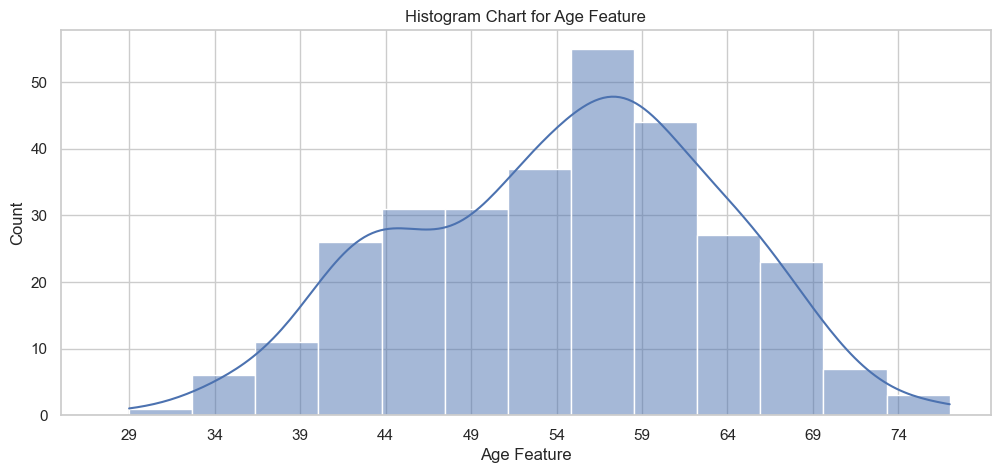

In [27]:
# Histogram Chart for Age Feature

plt.figure(figsize=(12, 5))

sns.histplot(data=df_data, x="age", kde=True)
plt.xticks(ticks=range(25, 80, 5))
plt.xticks(ticks=range(df_data["age"].min(), (df_data["age"].max() + 1), 5))
# plt.xticks(fontsize=10, rotation=90)

plt.xlabel('Age Feature')
# plt.xlabel('Age Feature', fontsize=10)
plt.title("Histogram Chart for Age Feature")
plt.savefig("charts/chart1_age_histogram.png", dpi=300)
plt.show()

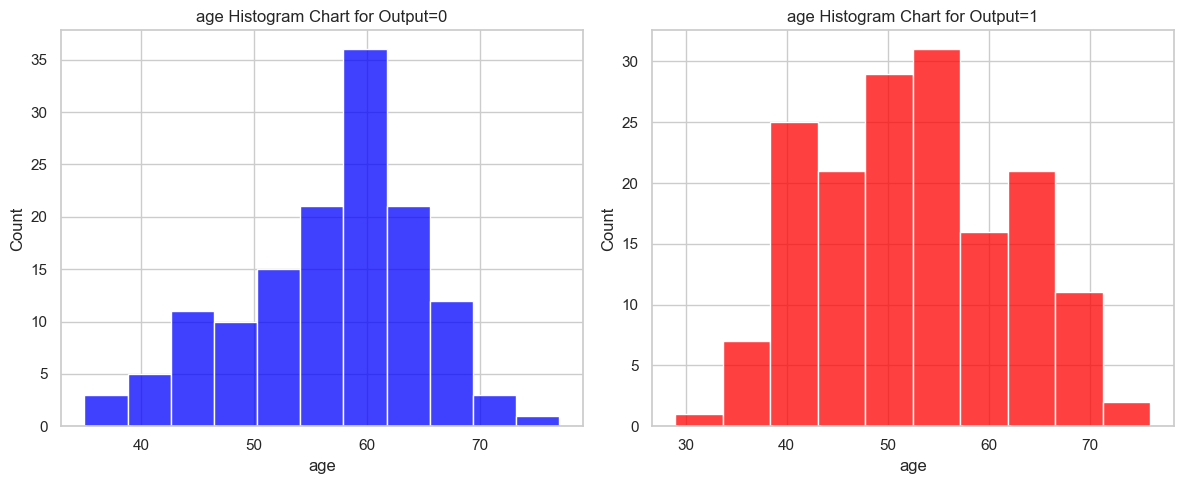

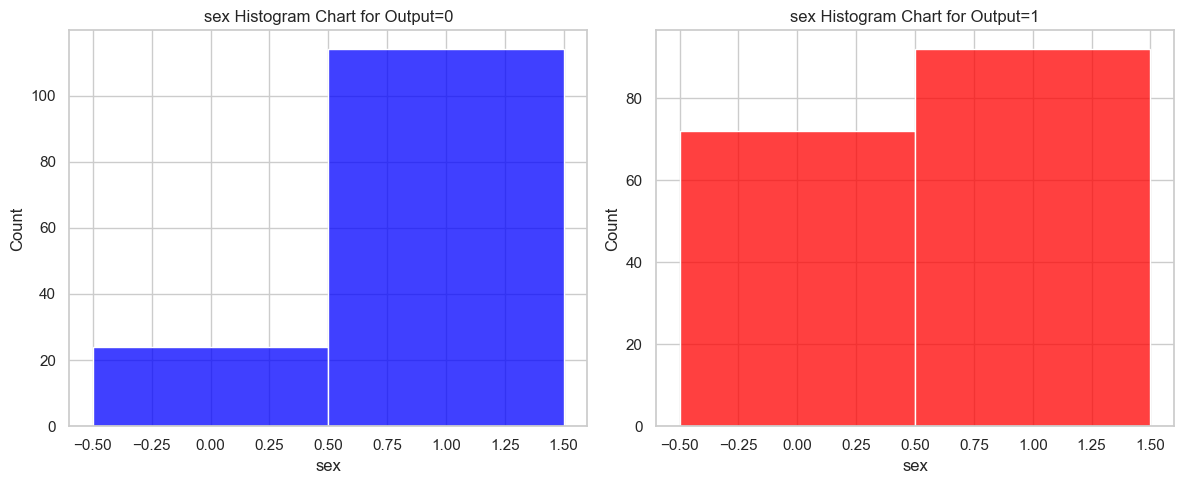

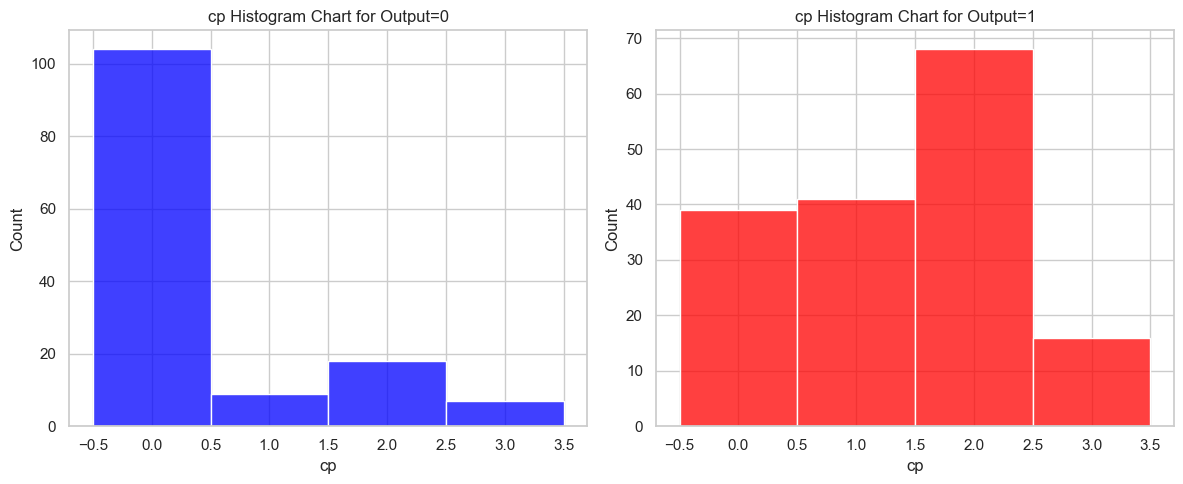

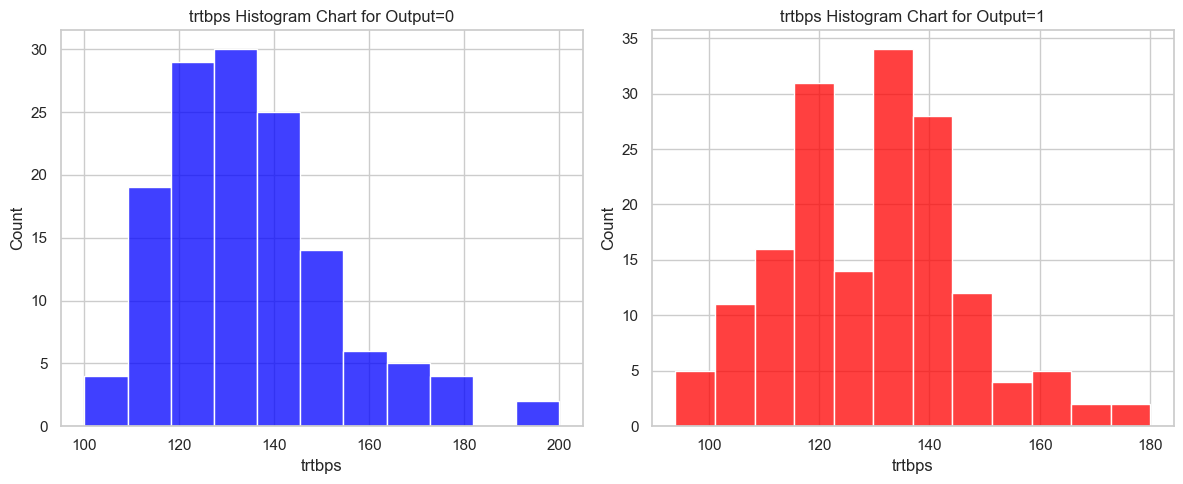

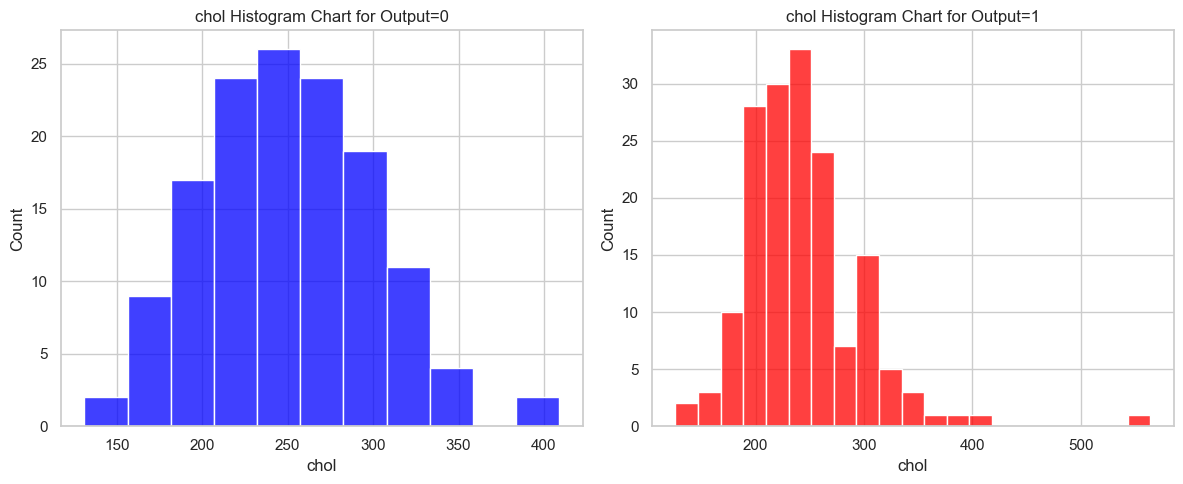

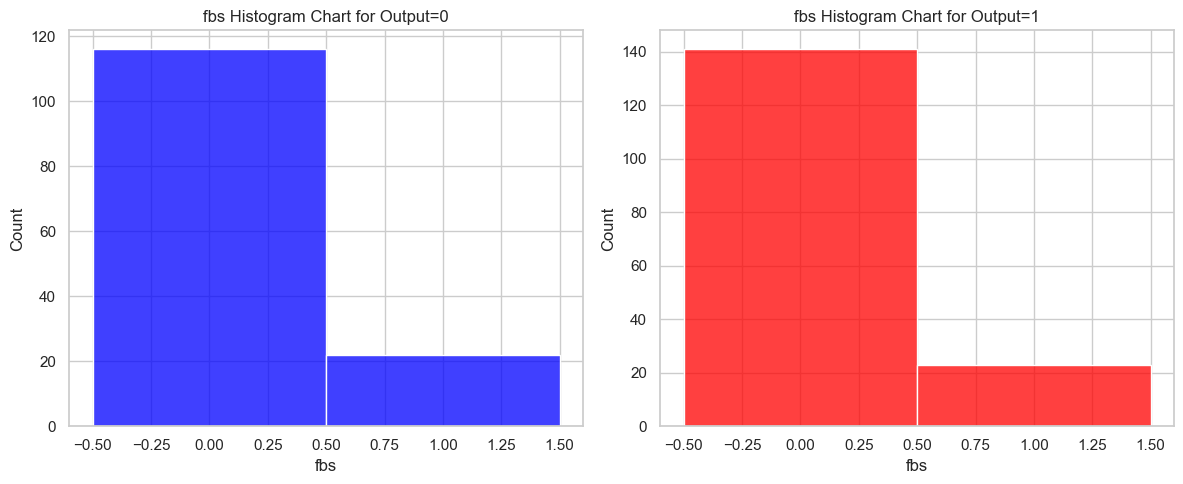

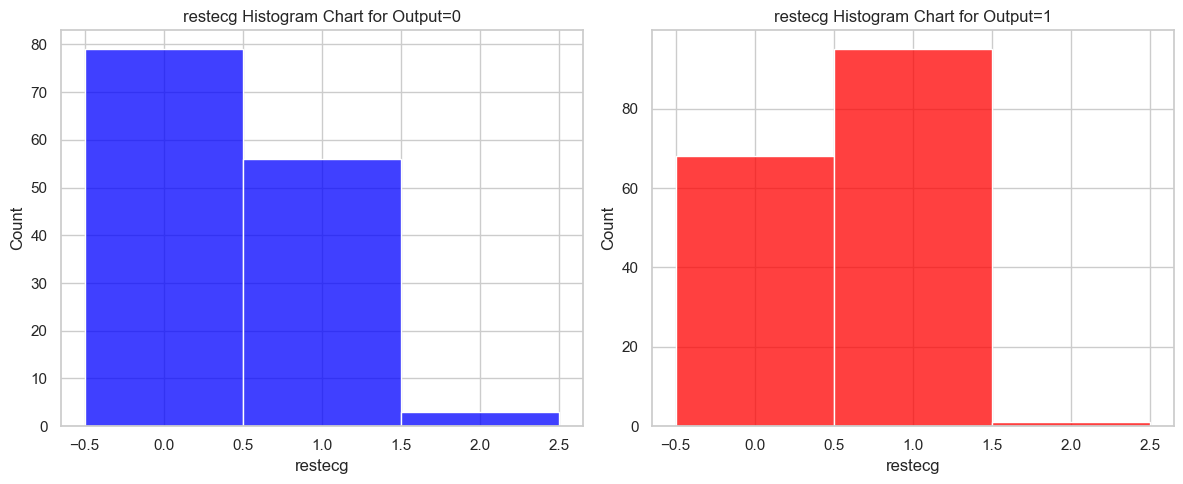

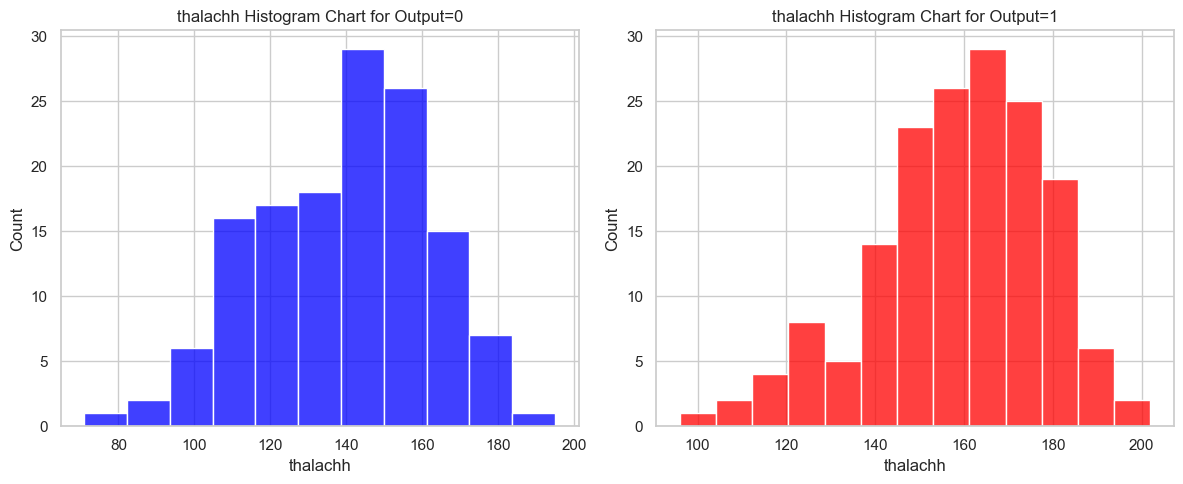

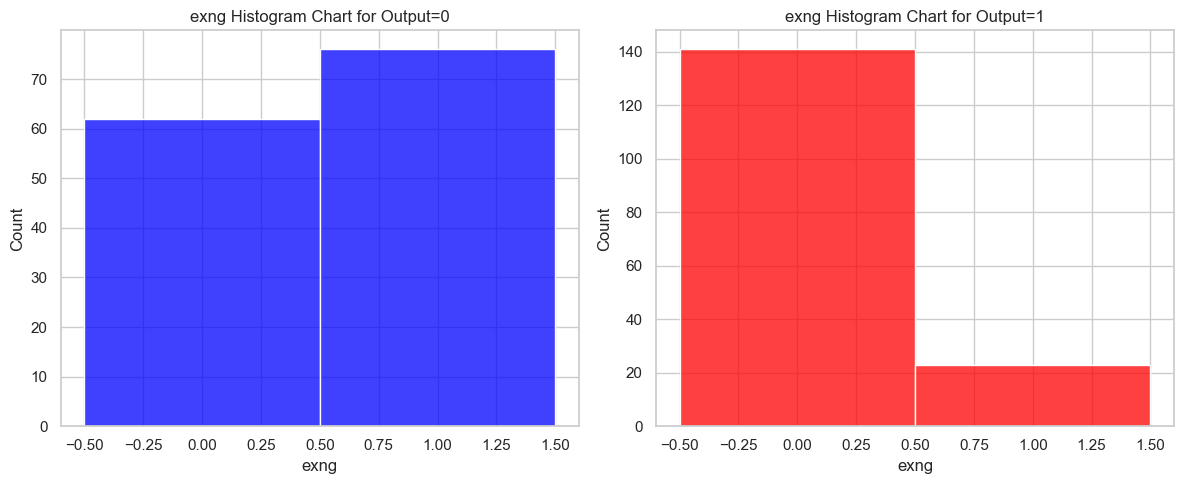

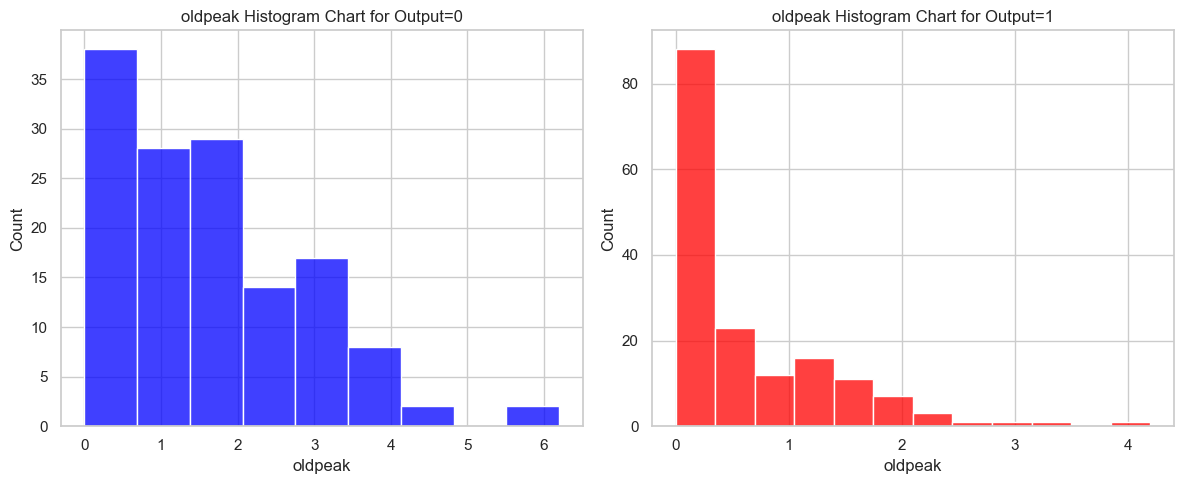

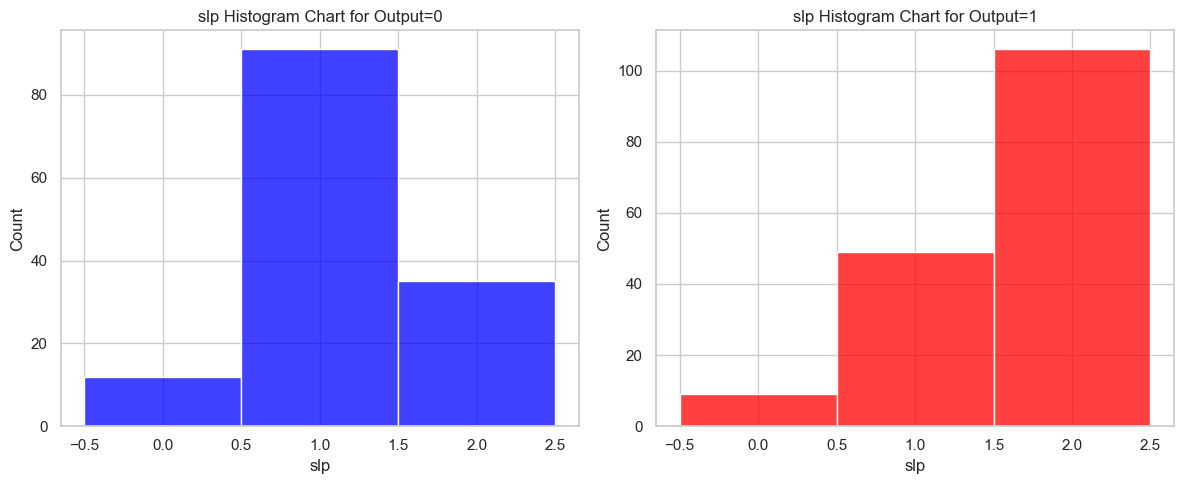

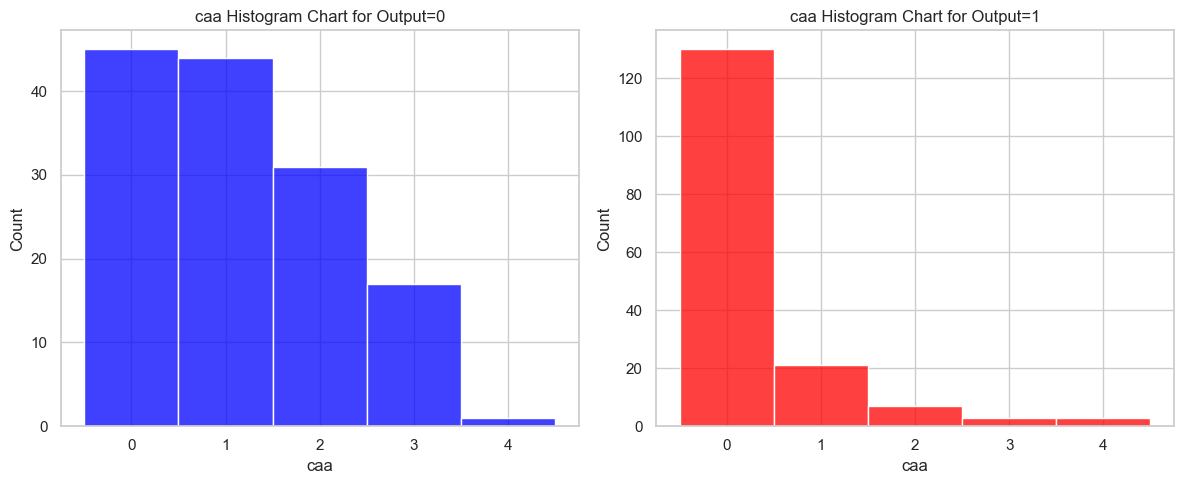

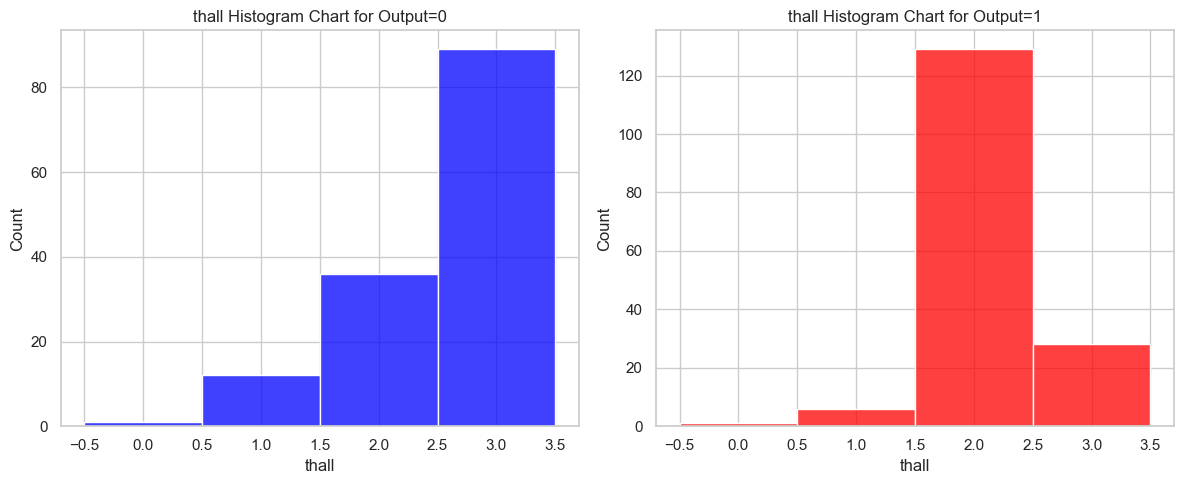

In [28]:
# Each Histogram Chart for each Output values

for feature in df_data.columns[:-1]:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df_data[df_data['output'] == 0], x=feature, kde=False, color='blue')
    plt.title(f'{feature} Histogram Chart for Output=0')
    plt.xlabel(feature)

    plt.subplot(1, 2, 2)
    sns.histplot(data=df_data[df_data['output'] == 1], x=feature, kde=False, color='red')
    plt.title(f'{feature} Histogram Chart for Output=1')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.savefig("charts/" + f'{feature}_histogram.png', dpi=300)

    plt.show()

# Step 3: Modelling

In [ ]:
# Sınıflandırma için Python’da hazır kütüphanelerden faydalanınız. 
# Öğrenme modeli olarak k-en yakın komşuluk, karar ağaçları ve yapay nöron ağları (Backpropagation) yöntemlerini kullanınız. 
# Eğitim ve doğrulama için k-fold cross validation yöntemini kullanınız. 
# Doğrulama aşamasında doğrulama için ayırdığınız örnekler ile eğittiğiniz her öğrenme modelleri için en uygun parametreler ile en başarılı versiyonu belirleyiniz.
# (Örneğin karar ağacında gerekiyorsa ağacı budayınız, k-en yakın komşulukta farklı k değerleri alınız v.b.). 

#### Correlation with HeatMap

In [29]:
# df_data[num_feature_list].corr()
df_data.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.094962,-0.063107,0.283121,0.207216,0.119492,-0.111590,-0.395235,0.093216,0.206040,-0.164124,0.302261,0.065317,-0.221476
sex,-0.094962,1.000000,-0.051740,-0.057647,-0.195571,0.046022,-0.060351,-0.046439,0.143460,0.098322,-0.032990,0.113060,0.211452,-0.283609
cp,-0.063107,-0.051740,1.000000,0.046486,-0.072682,0.096018,0.041561,0.293367,-0.392937,-0.146692,0.116854,-0.195356,-0.160370,0.432080
trtbps,0.283121,-0.057647,0.046486,1.000000,0.125256,0.178125,-0.115367,-0.048023,0.068526,0.194600,-0.122873,0.099248,0.062870,-0.146269
chol,0.207216,-0.195571,-0.072682,0.125256,1.000000,0.011428,-0.147602,-0.005308,0.064099,0.050086,0.000417,0.086878,0.096810,-0.081437
fbs,0.119492,0.046022,0.096018,0.178125,0.011428,1.000000,-0.083081,-0.007169,0.024729,0.004514,-0.058654,0.144935,-0.032752,-0.026826
restecg,-0.111590,-0.060351,0.041561,-0.115367,-0.147602,-0.083081,1.000000,0.041210,-0.068807,-0.056251,0.090402,-0.083112,-0.010473,0.134874
thalachh,-0.395235,-0.046439,0.293367,-0.048023,-0.005308,-0.007169,0.041210,1.000000,-0.377411,-0.342201,0.384754,-0.228311,-0.094910,0.419955
exng,0.093216,0.143460,-0.392937,0.068526,0.064099,0.024729,-0.068807,-0.377411,1.000000,0.286766,-0.256106,0.125377,0.205826,-0.435601
oldpeak,0.206040,0.098322,-0.146692,0.194600,0.050086,0.004514,-0.056251,-0.342201,0.286766,1.000000,-0.576314,0.236560,0.209090,-0.429146


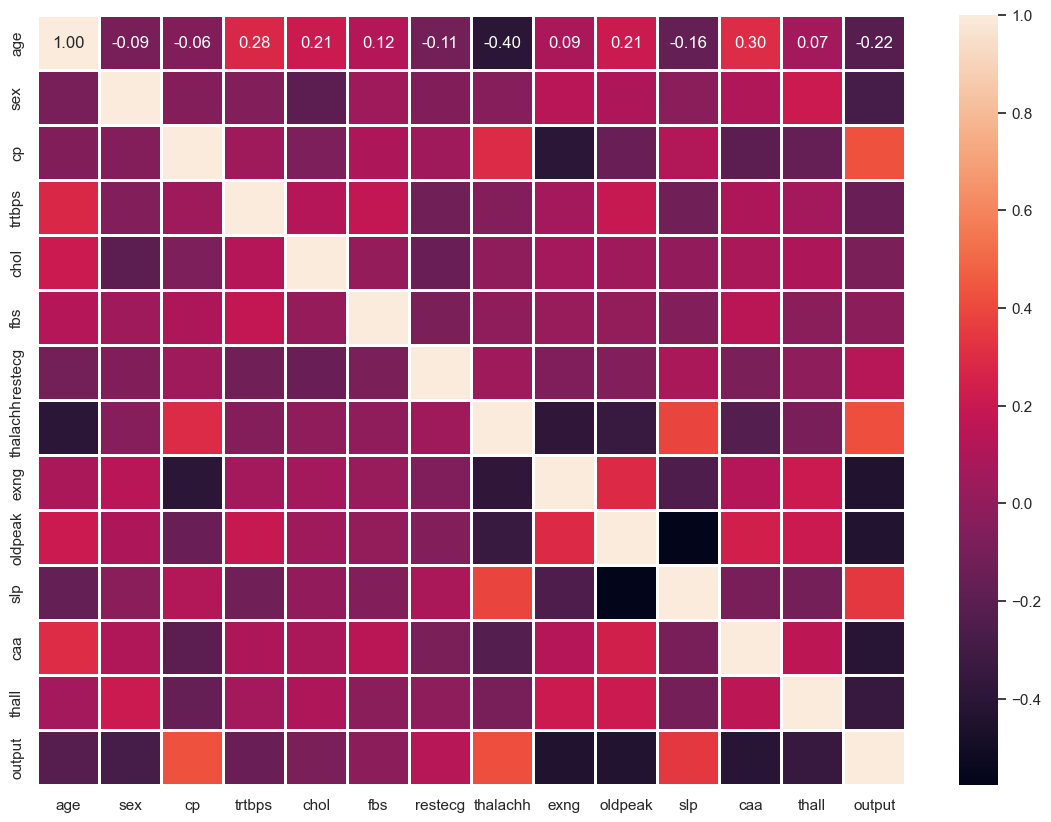

In [117]:
# Visualization of correlation with heatmap
plt.figure(figsize = (14,10))
sns.heatmap(df_data.corr(), annot = True, fmt = ".2f", linewidths = 2, )
plt.savefig("charts/correlation_heatmap.png", dpi=300)
plt.show()

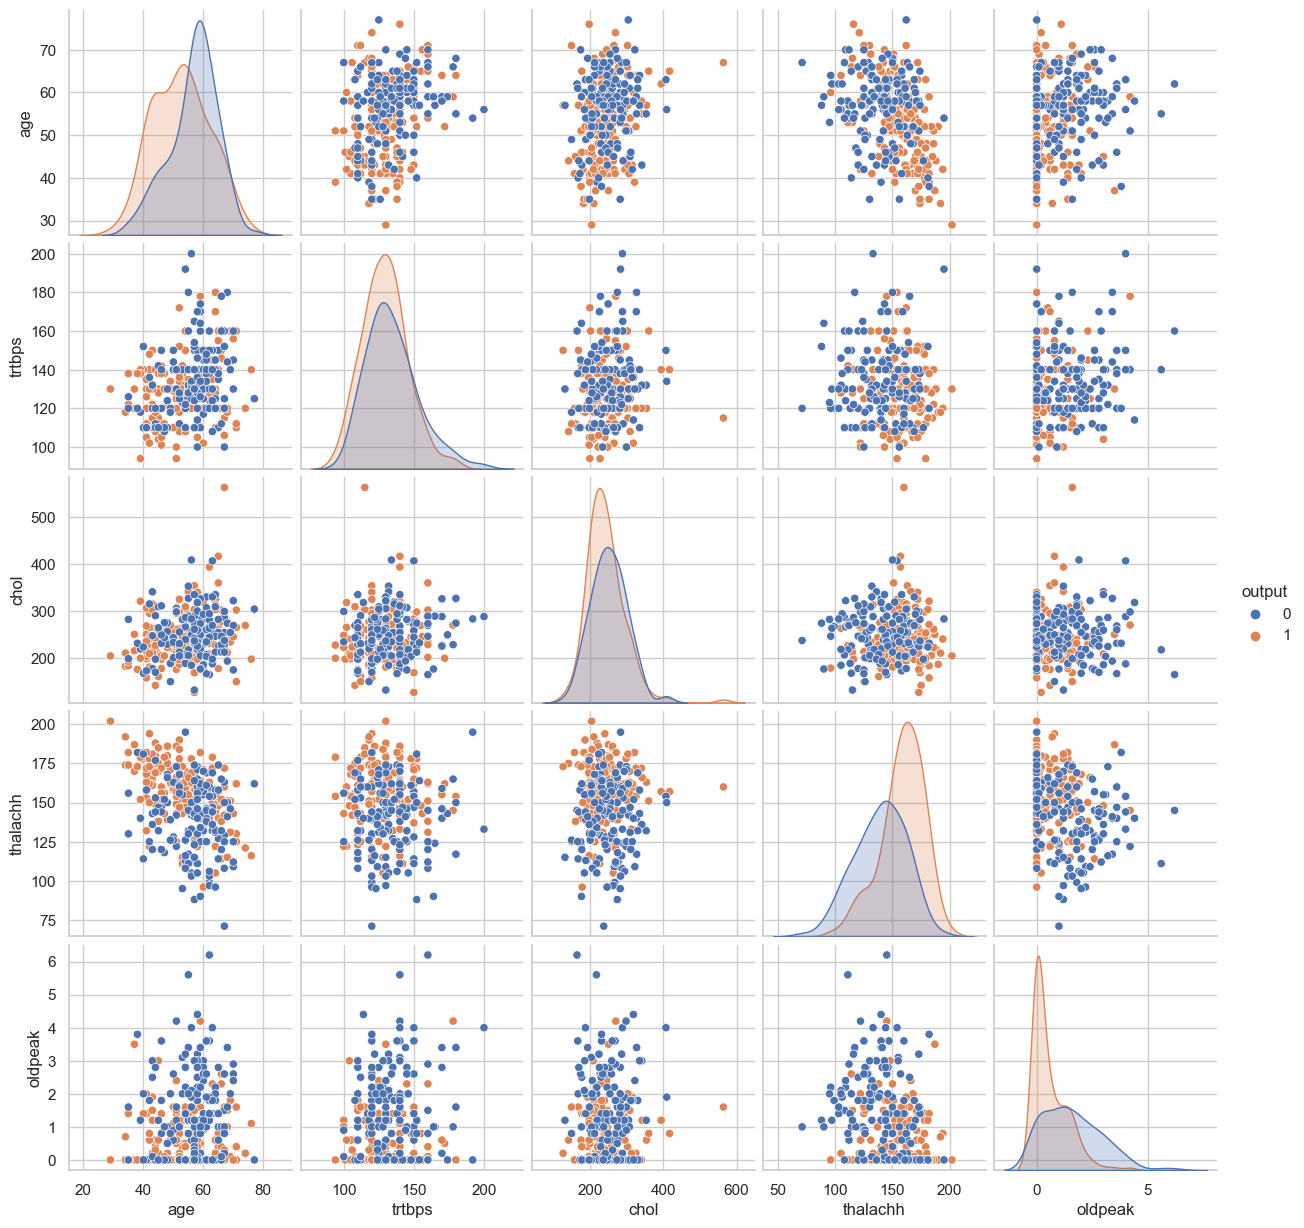

In [30]:
df_data_num = df_data.loc[:, (num_feature_list + ['output'])]
sns.pairplot(df_data_num, hue = "output", diag_kind = "kde")
plt.savefig("charts/pairplotwithoutput.png", dpi=300)
plt.show()

### Z-Score Standartization

In [35]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
trtbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
thalachh,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2


In [36]:
# We use Z-Score Standardization for numeric features due to algorithms using distance measurement.
# Distance Based Algorithms KNN, KMeans SVM

scaler = StandardScaler()

df_normalized_values = scaler.fit_transform(df_data[num_feature_list[:-1]])

df_data_normalized = pd.DataFrame(df_normalized_values, columns=df_data[num_feature_list[:-1]].columns)

df_data[num_feature_list[:-1]] = df_data_normalized

df_data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.949794,1,3,0.764066,-0.261285,1,0,0.018826,0,2.3,0,0,1,1
1,-1.928548,1,2,-0.091401,0.067741,0,1,1.636979,0,3.5,0,0,2,1
2,-1.485726,0,1,-0.091401,-0.822564,0,0,0.980971,0,1.4,2,0,2,1
3,0.174856,1,1,-0.661712,-0.203222,0,1,1.243374,0,0.8,2,0,2,1
4,0.285561,0,0,-0.661712,2.080602,0,1,0.587366,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.285561,0,0,0.478910,-0.106449,0,1,-1.161988,1,0.2,1,0,3,0
298,-1.042904,1,3,-1.232023,0.338703,0,1,-0.768384,0,1.2,1,0,3,0
299,1.503322,1,0,0.707035,-1.035462,1,1,-0.374779,0,3.4,1,2,3,0
300,0.285561,1,0,-0.091401,-2.235438,0,1,-1.511859,1,1.2,1,1,3,0


In [37]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,302.0,-2.588070e-16,1.001660,-2.814192,-0.710788,0.119503,0.728383,2.499671
trtbps,302.0,-7.058372e-16,1.001660,-2.144521,-0.661712,-0.091401,0.478910,3.900776
chol,302.0,8.822964e-18,1.001660,-2.332210,-0.687083,-0.116127,0.546763,6.145034
thalachh,302.0,-5.646697e-16,1.001660,-3.436149,-0.713716,0.128160,0.718568,2.292987
oldpeak,302.0,1.043046e+00,1.161452,0.000000,0.000000,0.800000,1.600000,6.200000


### Split Dataset

In [39]:
# Balanced Dataset
df_data['output'].value_counts()

output
1    164
0    138
Name: count, dtype: int64

In [40]:
df_train_data, df_test_data = train_test_split(df_data, test_size=0.2, random_state=23)
df_data.shape, df_train_data.shape, df_test_data.shape

((302, 14), (241, 14), (61, 14))

In [41]:
X_train, y_train = df_train_data.loc[:, feature_list], df_train_data["output"]
X_test, y_test = df_test_data.loc[:, feature_list], df_test_data["output"]

# Check the DataSet Shape for X and Y
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((241, 14), (241,), (61, 14), (61,))

In [42]:
# Control DataSet Shape
df_data.shape, df_train_data.shape, df_test_data.shape

((302, 14), (241, 14), (61, 14))

### K Fold Cross Validation

In [43]:
# K-fold Cross Validation Value 5, 10
k_fold_splits = 5

# Create K-fold object
kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=23)

## Model 1: KNN Algorithm

In [44]:
%%time

# Parametre Values for KNN Model
knn_param_dist = {'n_neighbors': np.arange(start=3, stop=11, step=2),
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski']} #Random Search
                  # 'p': 1/2

# KNN Model
knn_clf = KNeighborsClassifier()

# KNN Model with Random Search
knn_random_model = RandomizedSearchCV(knn_clf, knn_param_dist, cv=kf, scoring='accuracy')
knn_model = knn_random_model.fit(X_train, y_train)
knn_random_model_best_estimator = knn_model.best_estimator_
knn_random_model_best_params = knn_model.best_params_
knn_random_model_best_score = knn_model.best_score_

# Model Performance Evaluate
knn_random_scores = cross_val_score(knn_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

# summarize results
print("Best: %f using %s" % (knn_random_model_best_score, knn_random_model_best_params));print()

means = knn_model.cv_results_['mean_test_score']
stds = knn_model.cv_results_['std_test_score']
params = knn_model.cv_results_['params']

print("Id", "  Mean", "    StDev", "\t\t\t\t\tParam")
for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
    print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

# print()
# print("KNN Model with Random Search Best Parameters:", knn_random_model_best_params)
# print("KNN Model with Random Search Accuracy: {:.3f}".format(knn_random_scores.mean()))

Best: 0.933588 using {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}

Id   Mean     StDev 					Param
1 0.875340 (0.035272) with: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski'}
2 0.929422 (0.038698) with: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
3 0.875340 (0.035272) with: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
4 0.875510 (0.034876) with: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'minkowski'}
5 0.929507 (0.021056) with: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}
6 0.933588 (0.024345) with: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}
7 0.883759 (0.046892) with: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'minkowski'}
8 0.883759 (0.046892) with: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'}
9 0.875595 (0.069554) with: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'minkowski'}
10 0.883759 (0.046892) with: {'weights': 'distan

In [45]:
%%time
y_pred_knn_random = knn_random_model_best_estimator.predict(X_test)

CPU times: total: 0 ns
Wall time: 3.99 ms


Text(47.25, 0.5, 'True Labels')

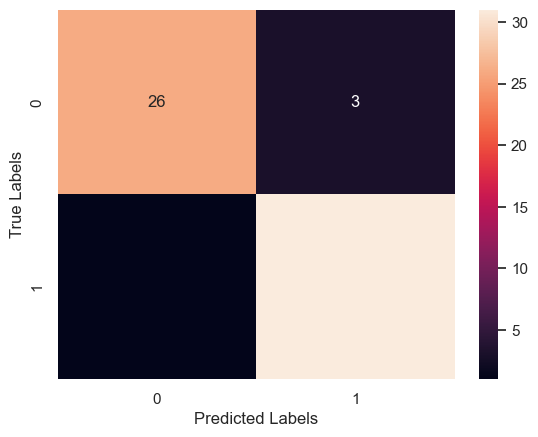

In [46]:
cm = confusion_matrix(y_pred=y_pred_knn_random, y_true=y_test)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

In [47]:
results_example = evaluate_classification(y_true=y_test, y_pred=y_pred_knn_random)
results_example

{'Accuracy': 0.9344262295081968,
 'Precision': 0.9117647058823529,
 'Recall': 0.96875,
 'F1 Score': 0.9393939393939394,
 'Confusion Matrix': array([[26,  3],
        [ 1, 31]], dtype=int64)}

In [48]:
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_knn_random))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        29
           1       0.91      0.97      0.94        32

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61



## Model 2: Decision Tree Algorithm

In [49]:
%%time

# Parametre Values for Decision Tree Model
dt_param_dist = {'criterion': ['gini', 'entropy'],
                 'max_depth': [3, 5, 7],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [3,5],
                 # 'max_features': [None, 'sqrt', 'log2', 0.5, 0.8]
}

# Decision Tree Model
dt_clf = DecisionTreeClassifier()

# Decision Tree Model with Random Search
dt_random_model = RandomizedSearchCV(dt_clf, dt_param_dist, n_iter=10, cv=kf, scoring='accuracy', random_state=23)
dt_model = dt_random_model.fit(X_train, y_train)
dt_random_model_best_estimator = dt_model.best_estimator_
dt_random_model_best_params = dt_model.best_params_
dt_random_model_best_score = dt_model.best_score_

# Model Performans Evaluate
dt_random_scores = cross_val_score(dt_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

# summarize results
print("Best: %f using %s" % (dt_random_model_best_score, dt_random_model_best_params));print()

means = dt_model.cv_results_['mean_test_score']
stds = dt_model.cv_results_['std_test_score']
params = dt_model.cv_results_['params']

print("Id", "  Mean", "    StDev", "\t\t\t\t\tParam")
for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
    print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

# print()
# print("Decision Tree Model with Random Search Best Parameters:", dt_random_model_best_params)
# print("Decision Tree Model with RandomSearch Accuracy: {:.3f}".format(dt_random_scores.mean()))

Best: 1.000000 using {'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'gini'}

Id   Mean     StDev 					Param
1 1.000000 (0.000000) with: {'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'gini'}
2 1.000000 (0.000000) with: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}
3 1.000000 (0.000000) with: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'entropy'}
4 1.000000 (0.000000) with: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 7, 'criterion': 'entropy'}
5 1.000000 (0.000000) with: {'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'criterion': 'entropy'}
6 1.000000 (0.000000) with: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'criterion': 'entropy'}
7 1.000000 (0.000000) with: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}
8 1.000000 (0.000000) with: {'min_samples_split':

In [50]:
# plot_tree(dt_random_model_best_estimator, filled=True, fontsize=14)

In [51]:
%%time
y_pred_dt_random = dt_random_model_best_estimator.predict(X_test)

CPU times: total: 0 ns
Wall time: 2.99 ms


Text(47.25, 0.5, 'True Labels')

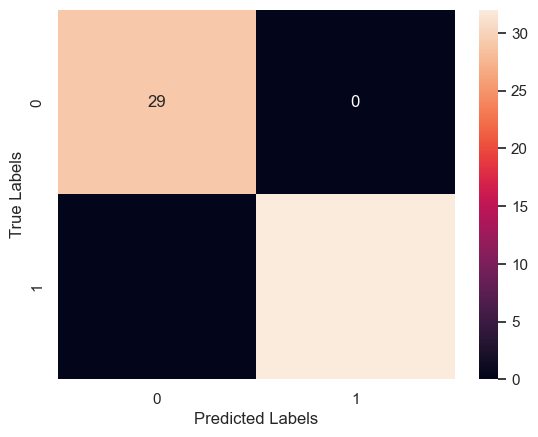

In [52]:
cm = confusion_matrix(y_pred=y_pred_dt_random, y_true=y_test)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

In [53]:
results_example = evaluate_classification(y_true=y_test, y_pred=y_pred_dt_random)
results_example

{'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1 Score': 1.0,
 'Confusion Matrix': array([[29,  0],
        [ 0, 32]], dtype=int64)}

In [54]:
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_dt_random))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        32

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



In [55]:
# fig = plt.figure(figsize=(16, 8))
# _ = plot_tree(dt_random_model_best_estimator, 
#               feature_names=feature_list,
#               filled=True,
#               class_names= ["1","0"],
#               fontsize=10)

## Model 3: Multilayer Perceptron Algorithm

In [112]:
%%time

# Parametre Values for MLP Model
mlp_param_dist = {'hidden_layer_sizes': [(5, ), (10, ), (15, )],
                  'activation': ['logistic', 'tanh', 'relu'],
                  'solver': ['sgd',],
                  'learning_rate': ['constant', 'invscaling', 'adaptive'],
                  'max_iter': [100, 150, 200],
                  'batch_size': [16, 32, 64, X_train.shape[0]],
                  'alpha': [1e-4, 1e-3, 1e-2],                  
                  } #Random Search

# MLP Model
mlp_clf = MLPClassifier()

# Multilayer Perceptron Model with Random Search
mlp_random_model = RandomizedSearchCV(mlp_clf, mlp_param_dist, n_iter=10, cv=kf, scoring='accuracy', random_state=23)
mlp_model = mlp_random_model.fit(X_train, y_train)

mlp_random_model_best_estimator = mlp_model.best_estimator_
mlp_random_model_best_params = mlp_model.best_params_
mlp_random_model_best_score = mlp_model.best_score_

# Model Performans Evaluate
mlp_random_scores = cross_val_score(mlp_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

# summarize results
print("Best: %f using %s" % (mlp_random_model_best_score, mlp_random_model_best_params));print()

means = mlp_model.cv_results_['mean_test_score']
stds = mlp_model.cv_results_['std_test_score']
params = mlp_model.cv_results_['params']

print("Id", "  Mean", "    StDev", "\t\t\t\t\tParam")
for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
    print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

# print()
# print("MLP Model with Random Search Best Parameters:", mlp_random_model_best_params)
# print("MLP Model with RandomSearch Accuracy: {:.3f}".format(mlp_random_scores.mean()))

Best: 0.958418 using {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}

Id   Mean     StDev 					Param
1 0.958418 (0.043741) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.543963 (0.094434) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.568112 (0.107663) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.946003 (0.046817) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.879337 (0.112234) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate':

In [113]:
%%time
y_pred_mlp_random = mlp_random_model_best_estimator.predict(X_test)

CPU times: total: 0 ns
Wall time: 3 ms


Text(47.25, 0.5, 'True Labels')

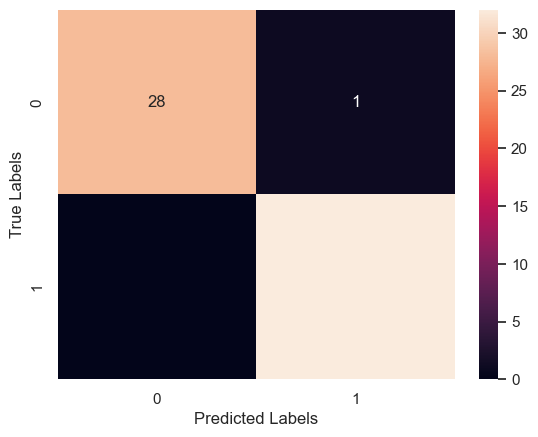

In [114]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_mlp_random)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

In [115]:
results_example = evaluate_classification(y_true=y_test, y_pred=y_pred_mlp_random)
results_example

{'Accuracy': 0.9836065573770492,
 'Precision': 0.9696969696969697,
 'Recall': 1.0,
 'F1 Score': 0.9846153846153847,
 'Confusion Matrix': array([[28,  1],
        [ 0, 32]], dtype=int64)}

In [116]:
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_mlp_random))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.97      1.00      0.98        32

    accuracy                           0.98        61
   macro avg       0.98      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61



# Step 4: Testing

In [ ]:
# print(list(y_test))
# print(list(y_pred_knn_random))

# print(list(y_test))
# print(list(y_pred_dt_random))

# print(list(y_test))
# print(list(y_pred_mlp_random))

In [61]:
model_list = {'KNN-RandomSearch' : [y_pred_knn_random],
              'DT-RandomSearch' : [y_pred_dt_random],
              'MLP-RandomSearch': [y_pred_mlp_random]}

for model in model_list.keys():
    print("Model Name:\t\t", model)
    for y_pred_value in model_list[model]:
        print("Y Test Value:\t\t", list(y_test))
        print("Y Pred Test Value:\t", list(y_pred_value))
        print("# " * 50);print();
        results_example = evaluate_classification(y_true=y_test, y_pred=y_pred_value)
        # print("Classfication Metrics:", results_example)
        print("Classfication Metrics:", pd.DataFrame.from_dict(data=results_example, orient='index'))
        print();print();

Model Name:		 KNN-RandomSearch
Y Test Value:		 [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Y Pred Test Value:	 [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Classfication Metrics:                                    0
Accuracy                    0.934426
Precision                   0.911765
Recall                       0.96875
F1 Score                    0.939394
Confusion Matrix  [[26, 3], [1, 31]]


Model Name:		 DT-RandomSearch
Y Test Value:		 [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0